In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from pytrack_analysis import Multibench
from pytrack_analysis.dataio import RawData, get_session_list
from pytrack_analysis.profile import get_profile, get_scriptname, show_profile
from pytrack_analysis.posttracking import frameskips, get_headflips
from pytrack_analysis.viz import plot_along, plot_fly, plot_interval, plot_overlay, plot_ts
import matplotlib.pyplot as plt

E:/Dennis/Google Drive/PhD Project/Tracking Analysis/profile\profile.yaml VERO-PC Windows_NT


ImportError: cannot import name 'get_headflips'

In [3]:
experiment = 'DIFF'
user = 'degoldschmidt'
ascript = '001-post_tracking.ipynb'

In [4]:
profile = get_profile(experiment, user, script=ascript)
load_from_file = True
folders = profile.get_folders()

System 'MacBook-Pro-3_x86_64_degoldschmidt' found.
Project 'DIFF' found.


In [5]:
### load video session data and metadata
this_session = 1
colnames = ['datetime', 'elapsed_time', 'frame_dt', 'body_x',   'body_y',   'angle',    'major',    'minor']
colunits = ['Datetime', 's',            's',        'px',       'px',       'rad',      'px',       'px']
session_data = RawData(experiment, this_session, folders, columns=colnames, units=colunits, noVideo=True)


Start post-tracking analysis for video session: 01
[pytrack_analysis.dataio]	Timestamp: Friday, 24. November 2017 08:26
[pytrack_analysis.dataio]	Warning: no video!
[pytrack_analysis.dataio]	Loading raw data...done.
[pytrack_analysis.arena]	loading geometry data...done.
[pytrack_analysis.food_spots]	loading food spots data...found a total of 48 spots...done.


In [9]:
### scale trajectories to mm
scale = 8.543
session_data.set_scale('fix_scale', scale, unit='mm')
### detect frameskips
frameskips(session_data, dt='frame_dt')

[pytrack_analysis.posttracking]	detected frameskips: 17 (0.016% of all frames)


In [10]:
session_data.flip_y()

[pytrack_analysis.posttracking]	Arena ↖ - mistracked frames: 0
Loading data from /Users/degoldschmidt/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/processed/post_tracking/DIFF_001.csv
[pytrack_analysis.posttracking]	Arena ↗ - mistracked frames: 0
Loading data from /Users/degoldschmidt/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/processed/post_tracking/DIFF_002.csv
[pytrack_analysis.posttracking]	Arena ↙ - mistracked frames: 0
Loading data from /Users/degoldschmidt/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/processed/post_tracking/DIFF_003.csv
[pytrack_analysis.posttracking]	Arena ↘ - mistracked frames: 0
Loading data from /Users/degoldschmidt/Google Drive/PhD Project/Experiments/001-DifferentialDeprivation/data/processed/post_tracking/DIFF_004.csv


In [121]:
def plot_arena(ax, arena=None, spots=None):
    spot_colors = {'yeast': '#ffc04c', 'sucrose': '#4c8bff'}
    ### artists
    if arena is not None:
        ax.set_xlim([-1.1*arena.ro, 1.1*arena.ro])
        ax.set_ylim([-1.1*arena.ro, 1.1*arena.ro])
        arena_border = plt.Circle((0, 0), arena.rr, color='k', fill=False)
        ax.add_artist(arena_border)
        outer_arena_border = plt.Circle((0, 0), arena.ro, color='#aaaaaa', fill=False)
        ax.add_artist(outer_arena_border)
        ax.plot(0, 0, 'o', color='black', markersize=2)
    if spots is not None:
        for each_spot in spots:
            substr = each_spot.substrate
            spot = plt.Circle((each_spot.rx, each_spot.ry), each_spot.rr, color=spot_colors[substr], alpha=0.5)
            ax.add_artist(spot)
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    return ax

<IPython.core.display.Javascript object>


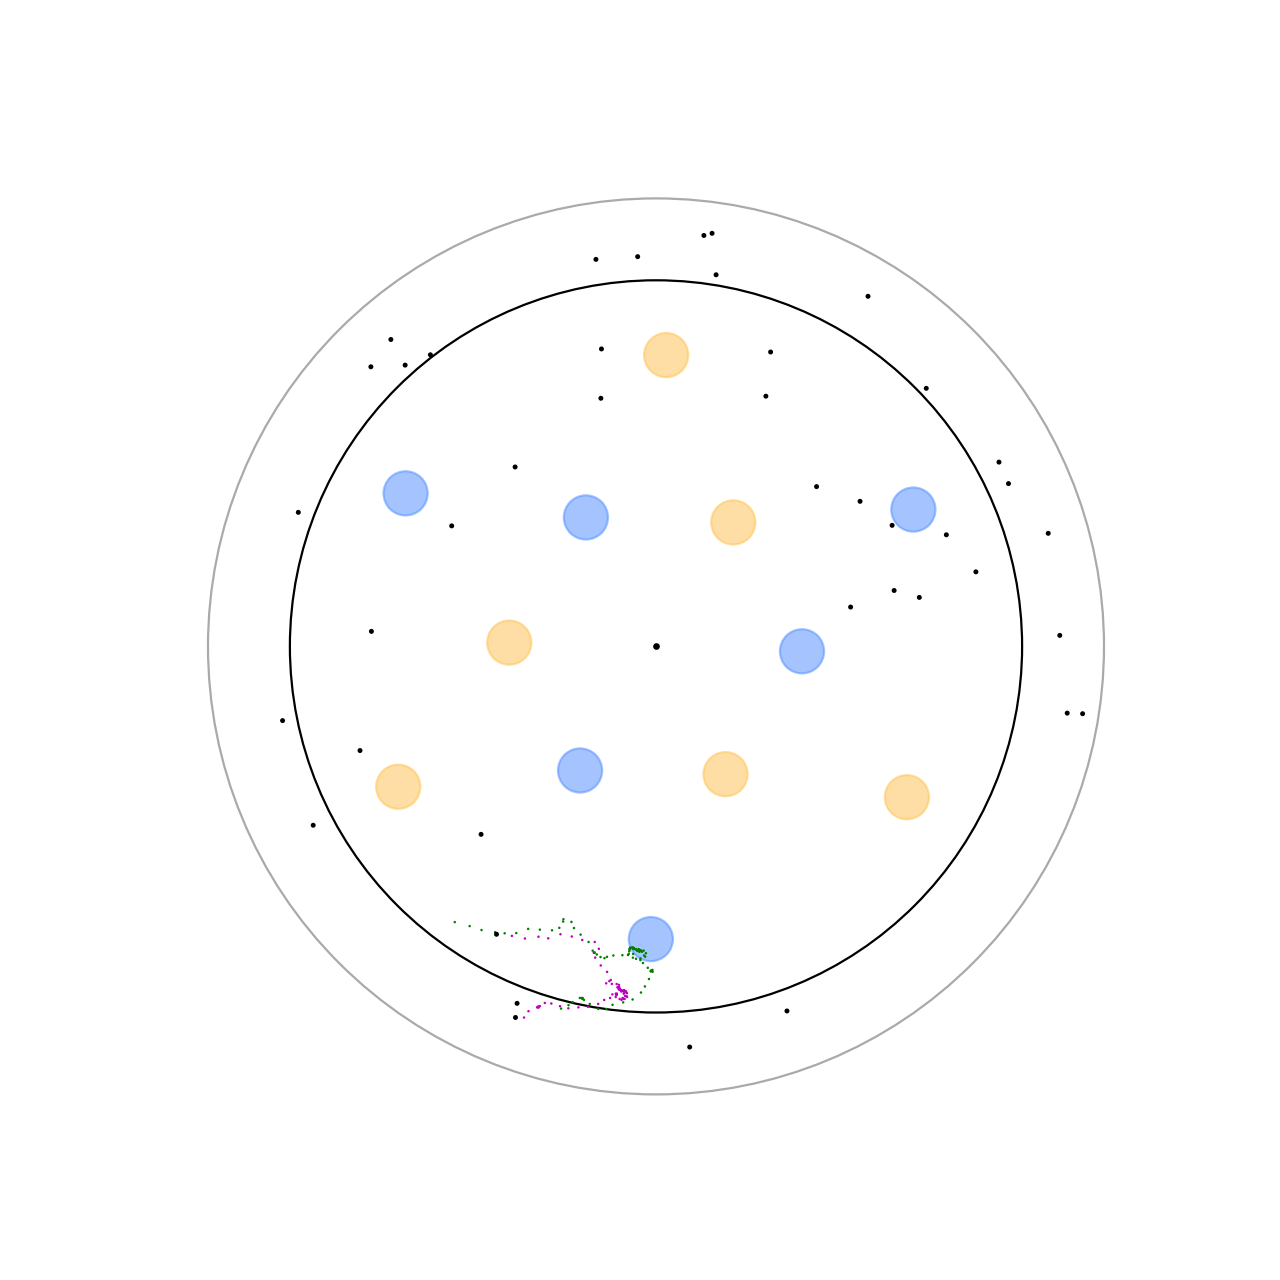

[ 6101  6224  6570  6683  7112  7152  7259  7332  7422  7541  7905  9129
  9180  9293  9354  9472  9656  9801  9887  9977 10014 10077 10214 10403
 10570 10749 10802 11123 11335 11500 11762 13802 14100 14292 14373 14750
 14812 15127 15337 15647 19892 27665]


In [135]:
index = 3
arena = session_data.arenas[index]
df = session_data.raw_data[index]
f, ax = plt.subplots(1, figsize=(8,8))
ax = plot_arena(ax, arena=arena, spots=arena.spots)
jumptimes = df.query('displacement > 1').index
jumptimes = np.append(start, jumptimes)
jumptimes = np.append(jumptimes, end)
djump = np.diff(jumptimes)
djump = np.append(42, djump) ## 42 to be larger than 30
min_diff = 30
jumptimes = jumptimes[djump > min_diff]
print(jumptimes)
jump_x = df.loc[jumptimes,'head_x'] 
jump_y = df.loc[jumptimes,'head_y']
tx = df.loc[9887:9977, 'tail_x']
ty = df.loc[9887:9977, 'tail_y']
hx = df.loc[9887:9977, 'head_x']
hy = df.loc[9887:9977, 'head_y']
ax.scatter(hx, hy, marker='.', s=5., c='m', edgecolor='none', zorder=5)
ax.scatter(tx, ty, marker='.', s=5., c='g', edgecolor='none', zorder=5)
ax.scatter(jump_x, jump_y, marker='.', s=20., c='k', edgecolor='none', zorder=5)
plt.show()

In [112]:
from datetime import timedelta
def traj(ax, data, x=None, y=None, speed=None, flip=None, time=None, arena=None, spots=None, start=None, end=None, title=None, **kwargs):
    ## styling
    if 's' in kwargs.keys():
        pointsize = kwargs['s']
    else:
        pointsize = 2
    spot_colors = {'yeast': '#ffc04c', 'sucrose': '#4c8bff'}
    
    ### artists
    if arena is not None:
        arena_border = plt.Circle((0, 0), arena.rr, color='k', fill=False)
        ax.add_artist(arena_border)
        outer_arena_border = plt.Circle((0, 0), arena.ro, color='#aaaaaa', fill=False)
        ax.add_artist(outer_arena_border)
        ax.plot(0, 0, 'o', color='black', markersize=2)
    if spots is not None:
        for each_spot in spots:
            substr = each_spot.substrate
            spot = plt.Circle((each_spot.rx, each_spot.ry), each_spot.rr, color=spot_colors[substr], alpha=0.5)
            ax.add_artist(spot)
        


    ### arrays where head is flipped or not
    if flip is not None:
        flips = np.array(data.loc[start:end, flip])
        x_flip = np.array(data.loc[start:end, x])[flips>0]
        y_flip = np.array(data.loc[start:end, y])[flips>0]
        x_noflip = np.array(data.loc[start:end, x])[flips==0]
        y_noflip = np.array(data.loc[start:end, y])[flips==0]
        ax.scatter(x_flip, y_flip, marker='.', c='g', edgecolor='none', zorder=5, s=pointsize)
        ax.scatter(x_noflip, y_noflip, marker='.', c='r', edgecolor='none', zorder=5, s=pointsize)
    ### speed plot
    if speed is not None:
        thr = 1
        timearray = np.array(data.loc[start:end, time].index)
        speeds = np.array(data.loc[start:end, speed])
        sspeeds = speeds[speeds>thr]
        jumptimes = data.query('displacement > 1').index
        jumptimes = np.append(start, jumptimes)
        jumptimes = np.append(jumptimes, end)
        djump = np.diff(jumptimes)
        djump = np.append(42, djump) ## 42 to be larger than 30
        min_diff = 30
        jumptimes = jumptimes[djump > min_diff]
        print(jumptimes)

        hx = np.array(data.loc[start:end, x])
        hy = np.array(data.loc[start:end, y])
        tx = np.array(data.loc[start:end, 'tail_x'])
        ty = np.array(data.loc[start:end, 'tail_y'])
        print(x)
        xjump = data.loc[jumptimes, 'body_x']
        yjump = data.loc[jumptimes, 'body_y']
        print(xjump)
        ax.scatter(xjump, yjump, marker='.', s=sspeeds*50, edgecolor='none', zorder=5)
 
    if arena is not None:
        ax.set_xlim([-1.1*arena.ro, 1.1*arena.ro])
        ax.set_ylim([-1.1*arena.ro, 1.1*arena.ro])
    ax.set_aspect("equal")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    tstr = timedelta(seconds=int(data.loc[start, time]))
    ax.set_title("{} s".format(tstr))
    ax.axis('off')
    return ax

<IPython.core.display.Javascript object>


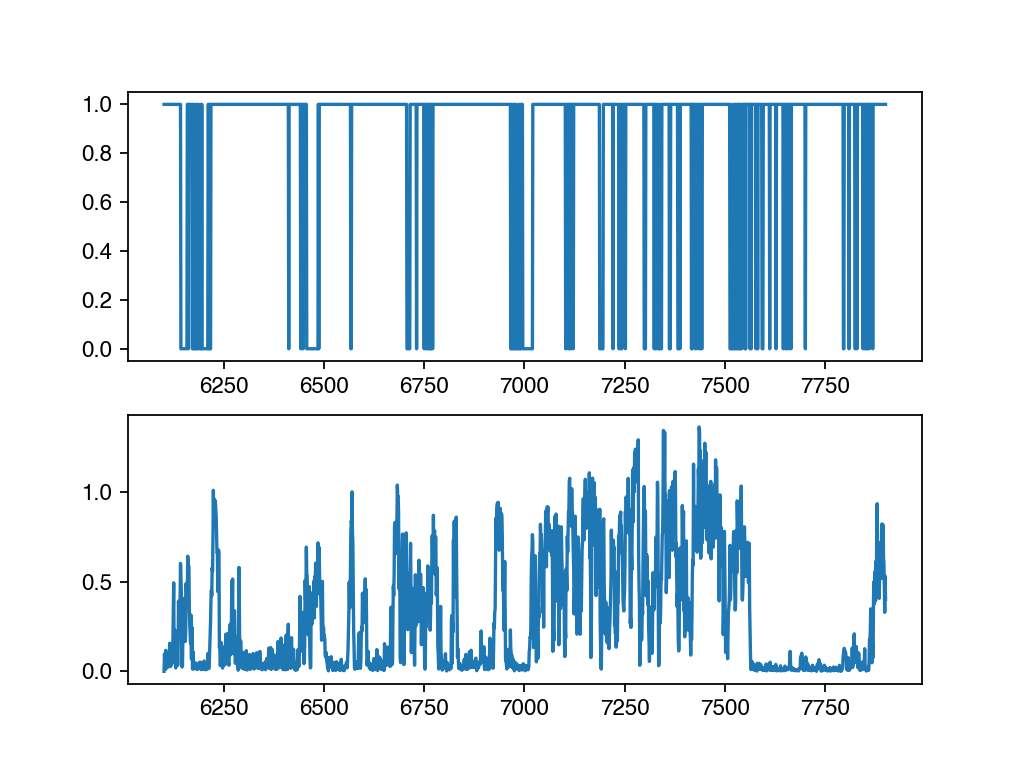

6101 7901
203.8287616


In [113]:
index = 3
f, ax = plt.subplots(2)
df = session_data.raw_data[index]
#start, end = 20000, 21000
start, end = df.index[0], df.index[-1]
start, end = df.index[0], df.index[0]+1800
print(start, end)
speed = df.loc[start:end, 'displacement']
print(df.loc[ df.index[0], 'elapsed_time'])
ax[0].plot(df.loc[start:end, 'flip'])
ax[1].plot(df.loc[start:end, 'displacement'])
plt.show()

6101 7901


<IPython.core.display.Javascript object>


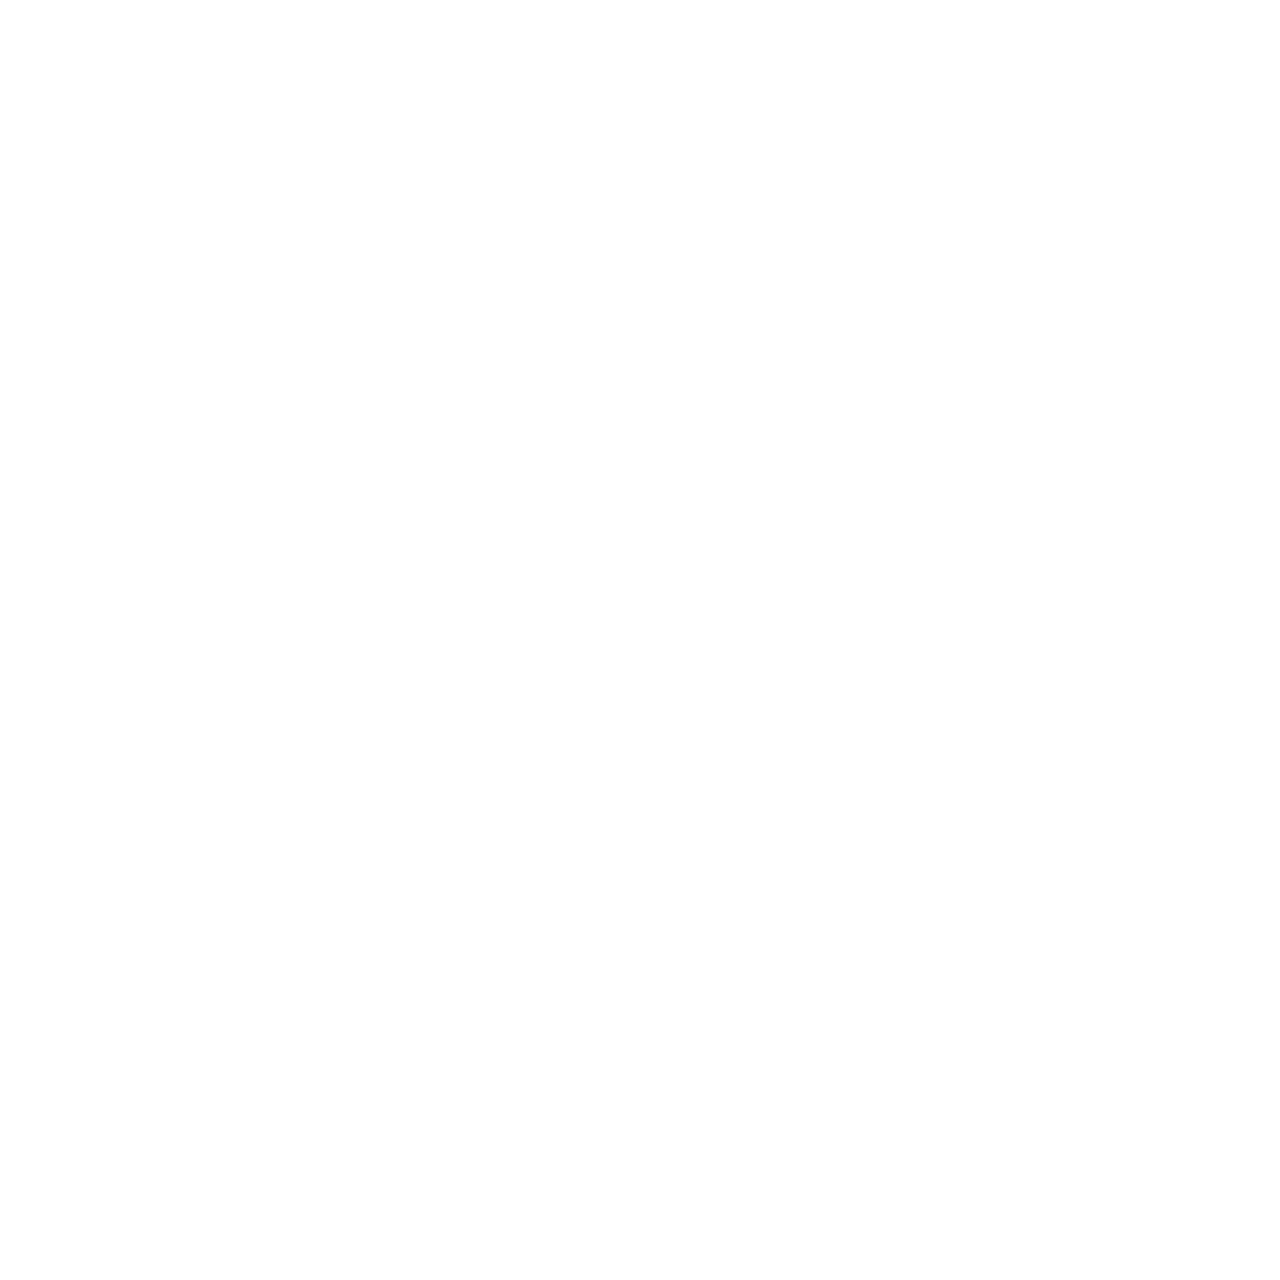

[6101 6224 6570 6683 7112 7152 7259 7332 7422 7541 7901]


KeyError: 'None of [[ 16.04094183  16.16362885  16.09747473 ...,  -1.05513539  -1.35981624\n  -1.62265316]] are in the [columns]'

In [98]:
%matplotlib notebook
print(start, end)
arena = session_data.arenas[index]

f, ax = plt.subplots(1, figsize=(8,8))
ax = traj(ax, session_data.raw_data[index], x='head_x', y='head_y', speed='displacement', time='elapsed_time', start=start, end=end, arena=arena, spots=arena.spots, s=20)

tx = np.array(df.loc[start:end, 'tail_x'])
ty = np.array(df.loc[start:end, 'tail_y'])
hx = np.array(df.loc[start:end, 'head_x'])
hy = np.array(df.loc[start:end, 'head_y'])
ax.scatter(hx, hy, marker='.', s=5., c='m', edgecolor='none', zorder=5)
ax.scatter(tx, ty, marker='.', s=5., c='g', edgecolor='none', zorder=5)
plt.show()
#f.savefig(_file, dpi=600)

In [133]:
def get_sumflip(array):
    return np.sum(array)/array.shape[0]

jumptimes = np.array(df.query('displacement > 1').index)
jumptimes = np.append(start, jumptimes)
jumptimes = np.append(jumptimes, end)
djump = np.diff(jumptimes)
djump = np.append(42, djump) ## 42 to be larger than 30
min_diff = 30
jumptimes = jumptimes[djump > min_diff]
print(jumptimes)
for i in range(1,jumptimes.shape[0]):
    delta = jumptimes[i] - jumptimes[i-1]
    maxdiff = 500.
    sumfl = get_sumflip(np.array(df.loc[jumptimes[i-1]:jumptimes[i-1]+min(delta,maxdiff), 'flip']))
    print(i-1, min(delta,maxdiff), sumfl)
    
print(jumptimes[18])

[ 6101  6224  6570  6683  7112  7152  7259  7332  7422  7541  7905  9129
  9180  9293  9354  9472  9656  9801  9887  9977 10014 10077 10214 10403
 10570 10749 10802 11123 11335 11500 11762 13802 14100 14292 14373 14750
 14812 15127 15337 15647 19892 27665]
0 123 0.58064516129
1 346 0.896253602305
2 113 1.0
3 429 0.846511627907
4 40 0.926829268293
5 107 0.851851851852
6 73 0.905405405405
7 90 0.802197802198
8 119 0.783333333333
9 364 0.909589041096
10 500.0 0.972055888224
11 51 0.923076923077
12 113 0.894736842105
13 61 0.693548387097
14 118 0.924369747899
15 184 0.881081081081
16 145 0.91095890411
17 86 0.965517241379
18 90 0.494505494505
19 37 0.552631578947
20 63 0.796875
21 137 0.876811594203
22 189 0.884210526316
23 167 0.827380952381
24 179 0.916666666667
25 53 0.907407407407
26 321 0.866459627329
27 212 0.835680751174
28 165 0.879518072289
29 262 0.749049429658
30 500.0 0.994011976048
31 298 0.862876254181
32 192 0.886010362694
33 81 0.621951219512
34 377 0.970899470899
35 62 0.6

9760.0 114100.0
0.00137050632062
start: 325.840448 0:05:25
end: 3805.4896512 1:03:25


<IPython.core.display.Javascript object>


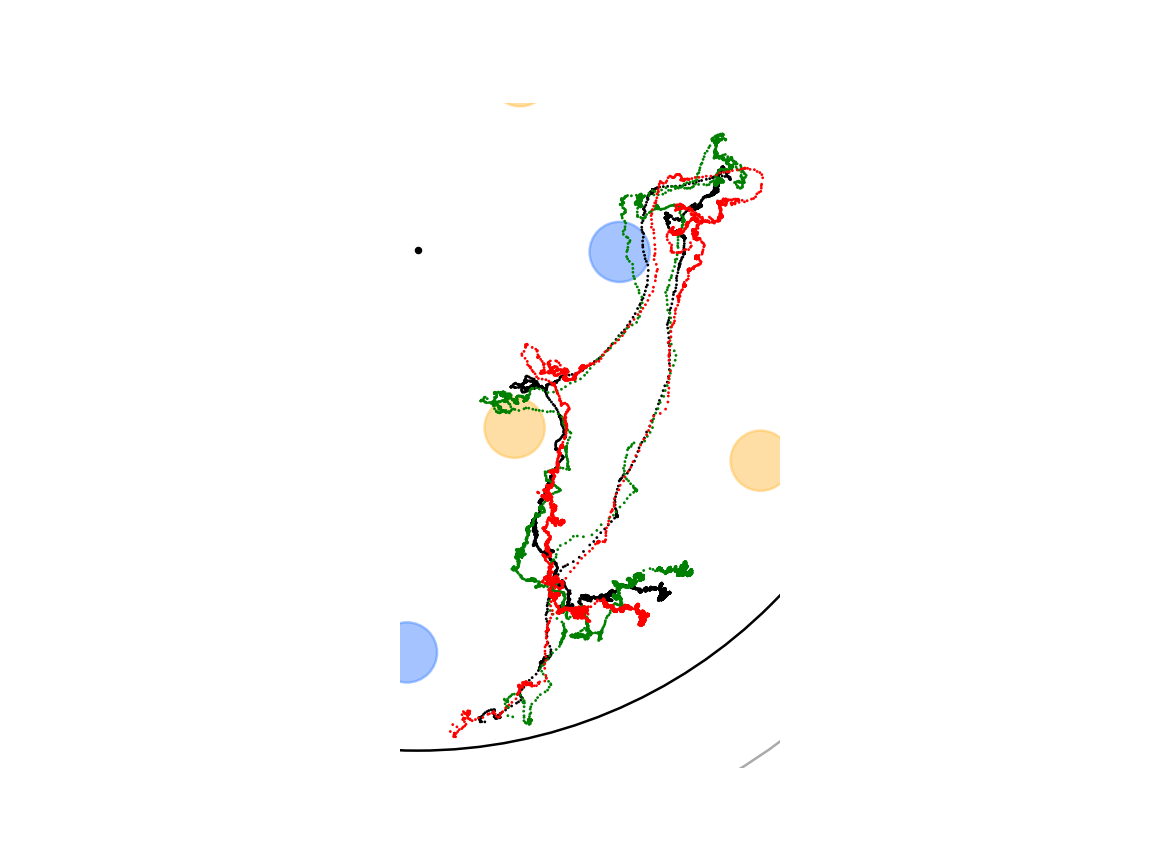

In [14]:
which = 7
x = df.loc[jumptimes[which]:jumptimes[which+1],'body_x']
y = df.loc[jumptimes[which]:jumptimes[which+1],'body_y']
hx = df.loc[jumptimes[which]:jumptimes[which+1],'head_x']
hy = df.loc[jumptimes[which]:jumptimes[which+1],'head_y']
tx = df.loc[jumptimes[which]:jumptimes[which+1],'tail_x']
ty = df.loc[jumptimes[which]:jumptimes[which+1],'tail_y']
tstr = timedelta(seconds=int(df.loc[jumptimes[which], 'elapsed_time']))
tstr1 = timedelta(seconds=int(df.loc[jumptimes[which+1], 'elapsed_time']))
print(jumptimes[which],jumptimes[which+1])
flips = np.array(df.loc[jumptimes[which]:jumptimes[which+1], 'flip'])
sumfl = np.sum(flips)/flips.shape[0]
print(sumfl)
print('start:', df.loc[jumptimes[which], 'elapsed_time'], "{}".format(tstr))
print('end:', df.loc[jumptimes[which+1], 'elapsed_time'], "{}".format(tstr1))


f, ax = plt.subplots(1)

spot_colors = {'yeast': '#ffc04c', 'sucrose': '#4c8bff'}
### artists
spots = arena.spots
if arena is not None:
    arena_border = plt.Circle((0, 0), arena.rr, color='k', fill=False)
    ax.add_artist(arena_border)
    outer_arena_border = plt.Circle((0, 0), arena.ro, color='#aaaaaa', fill=False)
    ax.add_artist(outer_arena_border)
    ax.plot(0, 0, 'o', color='black', markersize=2)
if spots is not None:
    for each_spot in spots:
        substr = each_spot.substrate
        spot = plt.Circle((each_spot.rx, each_spot.ry), each_spot.rr, color=spot_colors[substr], alpha=0.5)
        ax.add_artist(spot)

ax.scatter(x, y, marker='.', c='k', s=5, edgecolor='none', zorder=5)
ax.scatter(hx, hy, marker='.', c='g', s=5, edgecolor='none', zorder=5)
ax.scatter(tx, ty, marker='.', c='r', s=5, edgecolor='none', zorder=5)
#ax.set_xlim([-8,2])
#ax.set_ylim([-30, -20])
ax.set_aspect("equal")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
plt.show()